In [39]:
import numpy as np
import pandas as pd
import re
import nltk
import pickle
!pip install gTTS
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
# Load stop words
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [40]:
# Text Cleaning Function
def clean_text(raw_text):
    # Remove user handles (e.g., @username)
    text = re.sub(r"@[\w]*", "", raw_text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', raw_text, flags=re.MULTILINE)
    # Remove special characters, punctuation, and digits
    text = re.sub(r'\W', ' ', raw_text)
    text = re.sub(r'\d', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    tokenized_text = nltk.word_tokenize(text)
    cleaned_text = [word for word in tokenized_text if word.lower() not in stop_words]
    return " ".join(cleaned_text)



In [41]:
# Load Training Data from CSV
train_df = pd.read_csv('train.csv')

# Extract texts and labels
texts = train_df['tweet'].astype(str).apply(clean_text).tolist()
labels = train_df['class'].astype(int).tolist()

# Convert labels to categorical (one-hot encoding for multi-class classification with 3 classes)
labels = to_categorical(labels, num_classes=3)


In [42]:
# Load Testing Data from `test.txt`
with open('test.txt', 'r', encoding='utf-8') as f:
    test_texts = f.readlines()

# Clean the testing data
test_texts = [clean_text(text) for text in test_texts]


In [43]:
# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)  # Fit only on training data

# Convert texts to sequences
x_train = tokenizer.texts_to_sequences(texts)
x_test = tokenizer.texts_to_sequences(test_texts)

# Define maximum sequence length
max_length = 100

# Pad sequences to ensure uniform input size
x_train = pad_sequences(x_train, padding='post', maxlen=max_length)
x_test = pad_sequences(x_test, padding='post', maxlen=max_length)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved as tokenizer.pickle")


Tokenizer saved as tokenizer.pickle


In [55]:
# Define the CNN Model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [56]:
# Train the model on the full training data
cnn_history = cnn_model.fit(x_train, labels, epochs=10, batch_size=32, verbose=1)
cnn_model.summary()

Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.7820 - loss: 0.5793
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.8724 - loss: 0.3201
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.9028 - loss: 0.2461
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.9116 - loss: 0.2030
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9191 - loss: 0.1748
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.9207 - loss: 0.1670
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.9255 - loss: 0.1551
Epoch 8/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9338 - loss: 0.1468
Epoch 9/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.9325 - loss: 0.1502
Epoch 10/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9363 - loss: 0.1377


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 100)            │       3,437,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 96, 64)              │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 96, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,411,255 (39.72 MB)

 Trainable params: 3,470,375 (13.24 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 6,940,752 (26.48 MB)

In [45]:

# Save the trained model
cnn_model.save("trained_cnn_model.h5")
print("Model saved as trained_cnn_model.h5")

Model saved as trained_cnn_model.h5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


775/775 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - accuracy: 0.3693 - loss: 1.0248
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - accuracy: 0.7708 - loss: 0.6038
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.8816 - loss: 0.4645
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9048 - loss: 0.3804
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.9358 - loss: 0.3079
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.9466 - loss: 0.2803
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.9507 - loss: 0.2548
Epoch 8/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.9293 - loss: 0.2404
Epoch 9/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.8330 - loss: 0.2198
Epoch 10/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8634 - loss: 0.2043


Model saved as trained_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Predicted Labels for Test Data:
Test Sample 1:
Tweet: CB_Baby white_thunduh alsarabsss hes beaner smh tell hes mexicanyou bad boy
Predicted Class: 0 (Hate Speech)


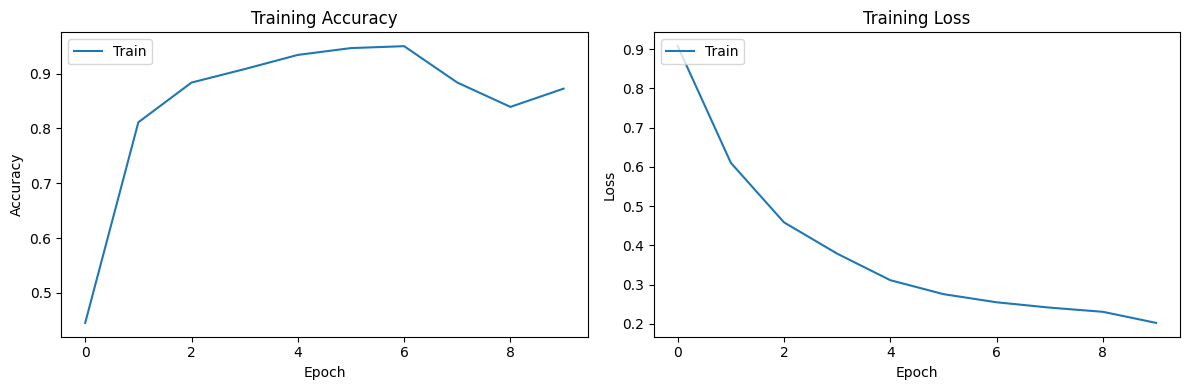

In [65]:
# import numpy as np
# import pandas as pd
# import nltk
# import re
# import pickle
# from sklearn.utils import class_weight
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# import matplotlib.pyplot as plt

# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# stop_words = set(nltk.corpus.stopwords.words('english'))

# # Function to clean text
# def clean_text(raw_text):
#     # Remove user handles (e.g., @username)
#     text = re.sub(r"@[\w]*", "", raw_text)
#     # Remove URLs
#     text = re.sub(r"http\S+|www\S+|https\S+", '', raw_text, flags=re.MULTILINE)
#     # Remove special characters, punctuation, and digits
#     text = re.sub(r'\W', ' ', text)
#     text = re.sub(r'\d', '', text)
#     # Remove extra whitespaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     # Tokenize and remove stopwords
#     tokenized_text = nltk.word_tokenize(text)
#     cleaned_text = [word for word in tokenized_text if word.lower() not in stop_words]
#     return " ".join(cleaned_text)

# # Load and preprocess the training data
# train_df = pd.read_csv('train.csv')
# texts = train_df['tweet'].astype(str).apply(clean_text).tolist()
# labels = train_df['class'].astype(int).tolist()

# # Convert labels to one-hot encoding
# labels = to_categorical(labels, num_classes=3)

# # Initialize the tokenizer and fit on training data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(texts)

# # Convert texts to sequences
# x_train = tokenizer.texts_to_sequences(texts)

# # Pad sequences to a fixed length
# max_length = 100
# x_train = pad_sequences(x_train, padding='post', maxlen=max_length)

# # Vocabulary size
# vocab_size = len(tokenizer.word_index) + 1

# # Save the tokenizer for later use
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Define the CNN model
# cnn_model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),
#     GlobalMaxPooling1D(),
#     Dense(10, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')  # Output layer for 3 classes
# ])

# # Compile the model
# cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Calculate class weights to handle class imbalance
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df['class']),
#     y=train_df['class']
# )
# class_weights = dict(enumerate(class_weights))

# # Train the model
# cnn_history = cnn_model.fit(x_train, labels, epochs=10, batch_size=32, class_weight=class_weights, verbose=1)

# # Save the trained model
# cnn_model.save("trained_cnn_model.h5")
# print("Model saved as trained_cnn_model.h5")

# # Load the testing data
# with open('test.txt', 'r') as file:
#     test_texts = file.readlines()

# # Preprocess testing data
# test_texts = [clean_text(text) for text in test_texts]

# # Convert test texts to sequences
# x_test = tokenizer.texts_to_sequences(test_texts)
# x_test = pad_sequences(x_test, padding='post', maxlen=max_length)

# # Load the trained model and make predictions
# cnn_model = load_model("trained_cnn_model.h5")
# y_pred_probs = cnn_model.predict(x_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Display predictions with updated labels
# label_mapping = {0: "Hate Speech", 1: "Offensive", 2: "Neither"}
# print("\nPredicted Labels for Test Data:")
# for i, (text, prediction) in enumerate(zip(test_texts, y_pred)):
#     print(f"Test Sample {i + 1}:")
#     print(f"Tweet: {text}")
#     print(f"Predicted Class: {prediction} ({label_mapping[prediction]})")

# # Plot training accuracy and loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(cnn_history.history['accuracy'])
# plt.title('Training Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')

# plt.subplot(1, 2, 2)
# plt.plot(cnn_history.history['loss'])
# plt.title('Training Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')

# plt.tight_layout()
# plt.show()



In [72]:

# Load the testing data
with open('test.txt', 'r') as file:
    test_texts = file.readlines()

# Preprocess testing data
test_texts = [clean_text(text) for text in test_texts]

# Convert test texts to sequences
x_test = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(x_test, padding='post', maxlen=max_length)

# Load the trained model and make predictions
cnn_model = load_model("trained_cnn_model.h5")
y_pred_probs = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Display predictions
print("\nPredicted Labels for Test Data:")
for i, (text, prediction) in enumerate(zip(test_texts, y_pred)):
    print(f"Test Sample {i + 1}:")
    print(f"Tweet: {text}")
    print(f"Predicted Class: {prediction} (0 = Hate Speech, 1 = Offensive, 2 = Neither)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Predicted Labels for Test Data:
Test Sample 1:
Tweet: hello fucking idiot dirty nigga
Predicted Class: 1 (0 = Hate Speech, 1 = Offensive, 2 = Neither)


In [73]:
# Predicting on `test.txt` data
y_pred_probs = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Display Predictions
print("\nPredicted Labels for `test.txt`:")
for i, prediction in enumerate(y_pred):
    print(f"Test sample {i + 1}: Predicted class {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Predicted Labels for `test.txt`:
Test sample 1: Predicted class 1


In [77]:
# Load the trained model
cnn_model = load_model("trained_cnn_model.h5")
print("Model loaded successfully.")

# Read testing data from text.txt
with open('test.txt', 'r') as file:
    test_lines = file.readlines()

test_lines = [clean_text(line.strip()) for line in test_lines]

# Tokenize and pad test data
test_sequences = tokenizer.texts_to_sequences(test_lines)
x_test_final = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# Predict using the model
predictions = cnn_model.predict(x_test_final)
predicted_classes = np.argmax(predictions, axis=1)

# Display predictions
for i, line in enumerate(test_lines):
    print(f"Tweet: {line}")
    print(f"Predicted Class: {predicted_classes[i]} (0 = Offensive, 1 = Hate Speech, 2 = Neither)")


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Tweet: hello dirty nigga
Predicted Class: 1 (0 = Offensive, 1 = Hate Speech, 2 = Neither)


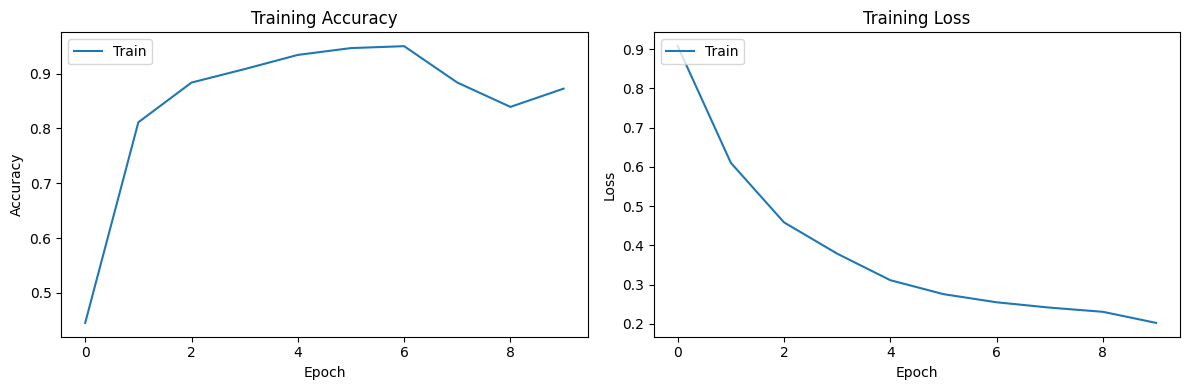

In [78]:
# Plotting Training Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plotting Training Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()


In [82]:
import numpy as np
import pandas as pd
import nltk
import re
!pip install gTTS
!pip install pydub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from gtts import gTTS
!pip install gTTS
!pip install pydub
from pydub import AudioSegment
from pydub.generators import Sine
import os

nltk.download('punkt')

# Load the test data from the txt file
with open('test.txt', 'r') as file:
    test_sentences = file.readlines()

# Load the pre-trained CNN model
cnn_model = load_model("trained_cnn_model.h5")

# Initialize the tokenizer (make sure this matches your training tokenizer)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_sentences)  # Assuming test set is representative; ideally, fit on the full dataset used in training

# Clean test data (same preprocessing used during training)
def clean_data(texts):
    def remove_user_handles(text):
        return re.sub(r"@[\w]+", "", text)

    def remove_urls(text):
        return re.sub(r"https?://\S+|www\.\S+", "", text)

    def remove_punctuation(text):
        return re.sub(r"[^\w\s]", "", text)

    cleaned_texts = []
    for text in texts:
        text = remove_user_handles(text)
        text = remove_urls(text)
        text = remove_punctuation(text)
        cleaned_texts.append(text)
    return cleaned_texts

# Preprocess the test data
cleaned_test_sentences = clean_data(test_sentences)

# Convert text to sequences
x_test = tokenizer.texts_to_sequences(cleaned_test_sentences)
x_test = pad_sequences(x_test, padding='post', maxlen=100)

# Predict classes using the CNN model
predictions = cnn_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Minimum confidence threshold for detecting offensive words
confidence_threshold = 0.7

# Function to detect offensive words using the CNN model
def detect_offensive_words(sentence):
    words = nltk.word_tokenize(sentence.lower())
    offensive_words = []

    # Check each word individually to see if it's offensive
    for word in words:
        # Preprocess and pad the single word for prediction
        sequence = tokenizer.texts_to_sequences([word])
        padded_sequence = pad_sequences(sequence, padding='post', maxlen=100)

        # Predict the class of the word
        word_prediction = cnn_model.predict(padded_sequence)
        word_prob = word_prediction[0][1]  # Probability of being offensive

        # If the word is classified as offensive with high confidence
        if word_prob > confidence_threshold:
            offensive_words.append(word)

    return offensive_words

# Function to censor offensive words in a text
def censor_text(text, offensive_words):
    words = nltk.word_tokenize(text.lower())
    censored_text = []

    for word in words:
        if word in offensive_words:
            censored_text.append("beep")
        else:
            censored_text.append(word)

    return " ".join(censored_text)

# Function to generate a beep sound
def generate_beep(duration=500):
    beep = Sine(1000).to_audio_segment(duration=duration).apply_gain(-10)
    return beep

# Function to create audio with censored offensive words
def create_audio_with_censor(text, filename="censored_output"):
    # Detect offensive words in the sentence using the CNN model
    offensive_words = detect_offensive_words(text)

    # Generate censored text
    censored_text = censor_text(text, offensive_words)
    print("Censored Text:", censored_text)

    # Split the censored text into words for processing
    words = censored_text.split()
    beep_sound = generate_beep(duration=500)
    output_audio = AudioSegment.empty()

    for word in words:
        if word == "beep":
            output_audio += beep_sound
        else:
            word_audio = gTTS(text=word, lang='en')
            temp_filename = f"{word}_temp.mp3"
            word_audio.save(temp_filename)
            word_segment = AudioSegment.from_file(temp_filename, format="mp3")
            output_audio += word_segment
            os.remove(temp_filename)

    # Export the final audio
    output_audio.export(f"{filename}.mp3", format="mp3")
    print(f"Audio saved as {filename}.mp3")

# Generate audio for all test sentences
for i, sentence in enumerate(test_sentences):
    filename = f"test_sentence_{i+1}"
    create_audio_with_censor(sentence, filename)

print("Audio files with censored content have been created.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Censored Text: beep bloody beep dirty
Audio saved as test_sentence_1.mp3
Audio files with censored content have been created.
